In [ ]:
import pandas as pd
import numpy as np
import sys
import os
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

core_dir = os.path.join(os.getcwd(), '..', 'core')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import stop_detection
import io
import pyarrow as pa
import pyarrow.parquet as pq
import s3fs
s3 = s3fs.S3FileSystem()

import seaborn as sns

## Extract a sample of 40000 users from 31 days

In [ ]:
s3_path = 's3://phl-pings/gravy_clean'
d_init = date(2019, 10, 7)
all_users = pd.Series(dtype='str', name='identifier')
for k in range(31):
    d = (d_init + timedelta(days=k)).isoformat()
    print(d)
    data = pq.read_table(f'{s3_path}/date={d}/', columns=['identifier'])
    users = data.column('identifier').unique().to_pandas()
    all_users = pd.concat([all_users, users]).drop_duplicates()

In [4]:
all_users.name = 'identifier'
all_users = all_users.sample(40000)
table = pa.Table.from_pandas(all_users.to_frame())
pq.write_table(table, f's3://robustness-project/user_sample.parquet', filesystem=s3)

## Subset data to sample of users

In [ ]:
user_sample = pq.read_table(f's3://robustness-project/user_sample.parquet').column('identifier').to_pandas()
output_data = []
d_init = date(2019, 10, 7)
for k in range(31):
    d = (d_init + timedelta(days=k)).isoformat()
    print(d)
    data = pq.read_table(f'{s3_path}/date={d}/').to_pandas().drop('mercator_coord', axis=1)
    subset_data = pd.merge(data, user_sample, on='identifier', how='inner')
    output_data += [subset_data]

In [6]:
# persist
sample_data = pd.concat(output_data, ignore_index=True)
table = pa.Table.from_pandas(sample_data)
pq.write_table(table, f's3://robustness-project/data_sample_40k.parquet', filesystem=s3)

# Incompleteness metrics

In [2]:
sample_data = pq.read_table(f's3://robustness-project/data_sample_40k.parquet').to_pandas()

## Barcode plots for different users

In [3]:
print(len(sample_data))
print(len(sample_data.drop_duplicates(['identifier', 'date_hour'])))

6573265
493761


In [4]:
# Plot barcodes
week1 = ('2019-10-08', '2019-10-15')
week2 = ('2019-10-15', '2019-10-22')
week3 = ('2019-10-22', '2019-10-29')
week4 = ('2019-10-29', '2019-11-05')

In [5]:
#select a user with 20 hours in a whole month
hour_counts = sample_data.groupby(['identifier']).date_hour.count()

In [8]:
user1 = hour_counts.loc[(hour_counts>100)&(hour_counts<600)].index[-1]
user2 = hour_counts.loc[(hour_counts>100)&(hour_counts<900)].index[0]
user3 = hour_counts.loc[(hour_counts>100)&(hour_counts<1000)].index[2]
hour_counts[[user1,user2,user3]]

identifier
fff24ee3-ed7b-40f4-80f2-d803c0b58498    237
0043bfa3-bc6a-3749-94bd-a34acf1851db    107
0066afc0-7dcf-3266-8548-db688eb21038    110
Name: date_hour, dtype: int64

In [77]:
def plot_user_timeframe(sample_data, user, start, end, ax=None):
    # If no Axes is passed in, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 1))  # Aspect ratio 10:1
        
    df = sample_data.loc[(sample_data['identifier'] == user) & 
                         (sample_data['local_timestamp'] > start) & 
                         (sample_data['local_timestamp'] < end)].copy()
    df['day_of_week'] = df['local_timestamp'].dt.dayofweek + df['local_timestamp'].dt.hour / 24.0 + df['local_timestamp'].dt.minute / 1440.0
    #plotting
    ax.hlines(1, 0, 6, color='gray', linewidth=2)
    ax.vlines(df['day_of_week'], 0.95, 1.05, color='gray', linewidth=5, alpha=0.08)
    ax.vlines(df['day_of_week'], 0.95, 1.05, color='gray', linewidth=10, alpha=0.08)
    ax.vlines(df['day_of_week'], 0.95, 1.05, color='black', linewidth=0.5)
    # Set x-axis details
    ax.set_xlim(0, 6)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    #ax.xaxis.set_label_coords(0.5, -0.5)
    #y-axis
    ax.yaxis.set_visible(False)
    [spine.set_visible(False) for spine in ax.spines.values()]    
    # Title with number of records
    ax.set_title(f"User {user[-4:]}, N={len(df)}, week={start}", fontsize=10, pad=10)
    return ax

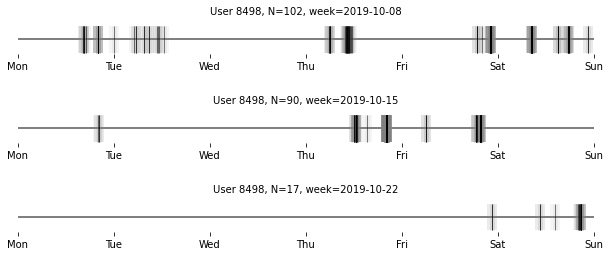

In [115]:
fig, axs = plt.subplots(3, 1, figsize=(10, 3.6))  # for 2 plots, one above the other
plot_user_timeframe(sample_data, user1, week1[0], week1[1], ax=axs[0])
plot_user_timeframe(sample_data, user1, week2[0], week2[1], ax=axs[1])
plot_user_timeframe(sample_data, user1, week3[0], week3[1], ax=axs[2])

fig.subplots_adjust(hspace=2.0, wspace=0.4, top=1.8, bottom=1.0, left=0.1, right=0.9)
plt.savefig('./user1.png')
plt.show()

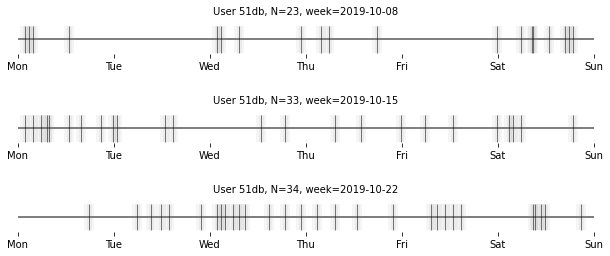

In [103]:
fig, axs = plt.subplots(3, 1, figsize=(10, 3.6))  # for 2 plots, one above the other
plot_user_timeframe(sample_data, user2, week1[0], week1[1], ax=axs[0])
plot_user_timeframe(sample_data, user2, week2[0], week2[1], ax=axs[1])
plot_user_timeframe(sample_data, user2, week3[0], week3[1], ax=axs[2])

fig.subplots_adjust(hspace=2.0, wspace=0.4, top=1.8, bottom=1.0, left=0.1, right=0.9)
fig.savefig('./user2.png')
plt.show()

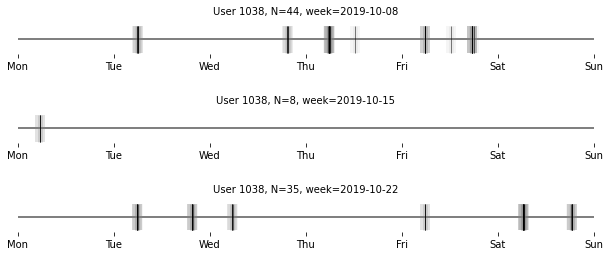

In [114]:
fig, axs = plt.subplots(3, 1, figsize=(10, 3.6))  # for 2 plots, one above the other
plot_user_timeframe(sample_data, user3, week1[0], week1[1], ax=axs[0])
plot_user_timeframe(sample_data, user3, week2[0], week2[1], ax=axs[1])
plot_user_timeframe(sample_data, user3, week3[0], week3[1], ax=axs[2])

fig.subplots_adjust(hspace=2.0, wspace=0.4, top=1.8, bottom=1.0, left=0.1, right=0.9)
fig.savefig('./user3.png')
plt.show()

## q score for each week

In [139]:
start, end = week1

window = sample_data.loc[(sample_data['local_timestamp'] > start) & 
                         (sample_data['local_timestamp'] < end)].drop_duplicates(['identifier', 'date_hour'])
user_hours = window.groupby(['identifier']).date_hour.count()

In [140]:
user_hours[(user_hours>=3)]

identifier
0009fc00-3e9c-3b36-a4d8-d84765ce5a0d     3
000fab4b-918f-3986-87e2-2949eda032e1     3
00121d05-3e99-3a61-a735-47b0e2bec5d8    44
0014bf5d-7bfb-3eb0-91bd-32334a606ba1     3
002e51d3-a7db-3669-b938-2fe434d8324f     3
                                        ..
ffd9382e-a9dd-3667-9e6d-c94bf972a128     3
ffe28b9b-093e-30c4-acc5-d93c51ce0630     5
ffe83295-25dc-4ba0-b3b2-bec21caae0d8     7
fff14168-b1a8-4a42-bbca-a8309bdf7a9a     7
fff24ee3-ed7b-40f4-80f2-d803c0b58498    26
Name: date_hour, Length: 6269, dtype: int64

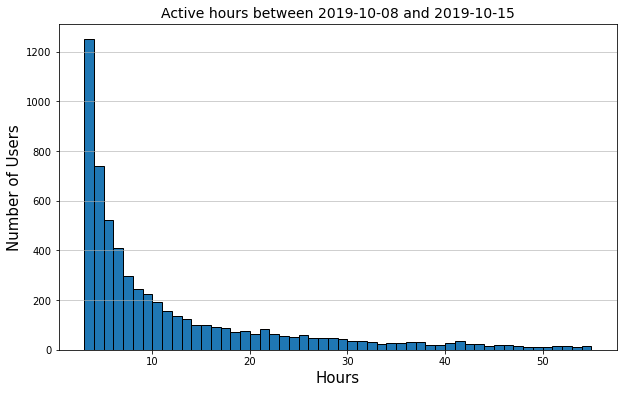

In [141]:
plt.figure(figsize=(10, 6))
plt.hist(user_hours[(user_hours>=3)], bins=range(3, 56), edgecolor='black')  # 168 bins
plt.title(f'Active hours between {start} and {end}', fontsize=14)  # Incorporate start and end into the title
plt.xlabel('Hours', fontsize=15)  # Increase font size for x-axis label
plt.ylabel('Number of Users', fontsize=15)  # Increase font size for y-axis label
plt.grid(axis='y', alpha=0.75)

# Save the figure
plt.savefig('./histogram.png')

# Show the plot
plt.show()

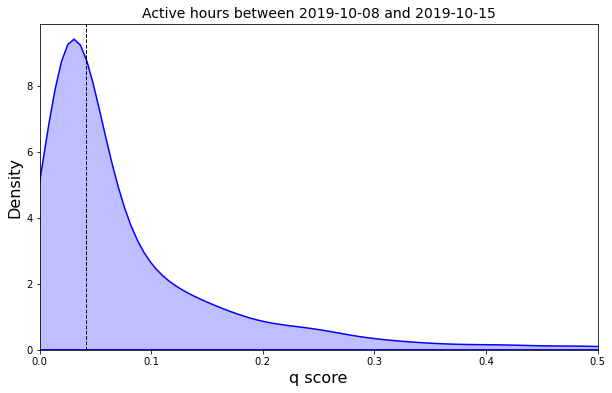

In [142]:
normalized_hours = user_hours[(user_hours>=3)] / 168

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(normalized_hours, shade=True, color="blue", linewidth=1.5)

# Calculate and plot the median line within the specified range
median_value = normalized_hours.median()
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)



# Set title and labels with increased font size
plt.title(f'Active hours between {start} and {end}', fontsize=14)
plt.xlabel('q score', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Limit the range of x-axis to be between 0 and 0.4
plt.xlim(0, 0.5)

# Save the figure
plt.savefig('normalized_hours_density.png')

# Show the plot
plt.show()